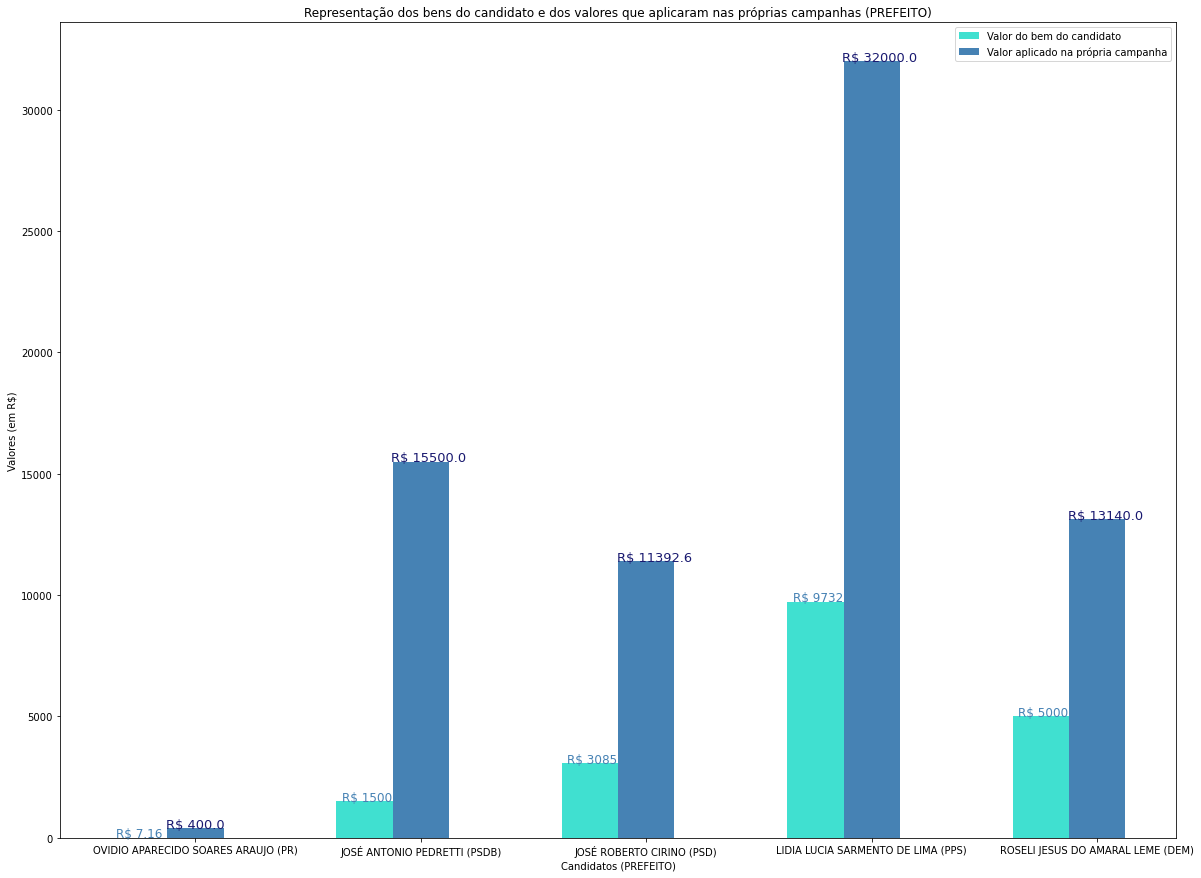

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Sat Oct 31 12:42:14 2020

@author: ISABPERE
"""

import pandas as pd
import os
import time
import numpy as np
import matplotlib.pyplot as plt

consulta_cand_sq_candidato_col = "SQ_CANDIDATO"
consulta_cand_nm_ue_col = "NM_UE"
consulta_cand_ds_cargo_col = "DS_CARGO"
consulta_cand_sg_uf_col = "SG_UF"
consulta_cand_nm_candidato_col = "NM_CANDIDATO"
consulta_cand_nr_cpf_candidato_col = "NR_CPF_CANDIDATO"
consulta_cand_sg_partido_col = "SG_PARTIDO"

bem_candidato_sq_candidato_col = "SQ_CANDIDATO"
bem_candidato_vr_bem_candidato_col ="VR_BEM_CANDIDATO"
bem_candidato_ds_bem_candidato_col = "DS_BEM_CANDIDATO"

receitas_candidatos_sequencial_candidatos_col = "Sequencial Candidato"
receitas_candidatos_cpf_candidato_col = "CPF do candidato"
receitas_candidatos_cpf_cnpj_doador_col = "CPF/CNPJ do doador"
receitas_candidatos_cpf_cnpj_doador_originario_col = "CPF/CNPJ do doador originário"
receitas_candidatos_valor_receita_col = "Valor receita"


despesas_candidatos_sequencial_candidato_col = "Sequencial Candidato"
despesas_candidatos_valor_despesa_col = "Valor despesa"


consulta_cand_file_name = "consulta_cand_2016_SP.csv"
bem_candidato_file_name = "bem_candidato_2016_SP.csv"
despesas_candidatos_file_name = "despesas_candidatos_prestacao_contas_final_2016_SP.txt"
receitas_candidatos_file_name = "receitas_candidatos_prestacao_contas_final_2016_SP.txt"

diferenca_porcentagem_col = "Diferença em Porcentagem"

sequencial_str = "SEQUENCIAL"
sq_str = "SQ"
cpf_str = "CPF"
vr_str = "VR"
valor_str = "VALOR"
engine_str = "python"
formato_porcentagem_str = "{0:.2f}%"
how_merge_str = "inner"
quote_char_str = '"'
sep_str = ";"
color_bar_receitas = 'steelblue'
color_bar_bens = 'turquoise'
color_bar_porcentagens = 'midnightblue'

leg_bem_candidato = 'Valor do bem do candidato'
leg_receita_campanha = 'Valor aplicado na própria campanha'
leg_diferenca_porc = 'Diferença de valores campanha x bens (em %)'
leg_candidatos = 'Candidatos'
leg_valores_reais = 'Valores (em R$)'
leg_porcentagem = 'Porcentagem'
tit_valores = 'Representação dos bens do candidato e dos valores que aplicaram nas próprias campanhas'
tit_porcentagem = 'Representação da diferença entre valor aplicado à própria campanha e bens declarados'

files_path = os.getcwd() + "\\"

def converte_tipo_colunas(df):
    
    for col in df.columns:
        col_uc = col.upper()
        if sequencial_str in col_uc or sq_str in col_uc or cpf_str in col_uc:
            df[col] = df[col].astype(str)
            
        elif (vr_str in col_uc or valor_str in col_uc) and df.dtypes[col] == object:
            df[col] = df[col].str.replace(",",".")   
            df[col] = df[col].astype(float)

    return df


def abre_arquivo(path, file):
    
    df = pd.read_csv(path + file, sep= sep_str, engine = engine_str,
                     quotechar = quote_char_str, error_bad_lines=False)
    
    df = converte_tipo_colunas(df)
    
    return df


def soma_valores_bens(df):

    df[bem_candidato_ds_bem_candidato_col] = df[
            [bem_candidato_sq_candidato_col,
            bem_candidato_ds_bem_candidato_col]
            ].groupby([
            bem_candidato_sq_candidato_col
            ])[bem_candidato_ds_bem_candidato_col].transform(lambda x: '; '.join(x))

    df = df.groupby([
            bem_candidato_sq_candidato_col,
            bem_candidato_ds_bem_candidato_col
            ])[bem_candidato_vr_bem_candidato_col].sum().round(2).reset_index()
    
    return df


def soma_valores_receitas(df):
    
    df = df.groupby([receitas_candidatos_sequencial_candidatos_col,
                     receitas_candidatos_cpf_candidato_col, 
                     receitas_candidatos_cpf_cnpj_doador_col])[receitas_candidatos_valor_receita_col].sum().round(2).reset_index()
 
        
    df = df[df[receitas_candidatos_cpf_candidato_col] == 
            df[receitas_candidatos_cpf_cnpj_doador_col]].reset_index(drop=True)
    
    return df


def ordena_e_calcula_porcentagem(df):
    
    df[diferenca_porcentagem_col] = ((df[receitas_candidatos_valor_receita_col] / 
      df[bem_candidato_vr_bem_candidato_col]) * 100)

    df.sort_values(diferenca_porcentagem_col, ascending=False, inplace=True)
    
    df.reset_index(drop = True, inplace = True)

    return df

    
def trata_e_mescla_dfs():
    
    
    receitas_candidatos_df = abre_arquivo(files_path, receitas_candidatos_file_name)
    bem_candidato_df = abre_arquivo(files_path, bem_candidato_file_name)
    consulta_cand_df = abre_arquivo(files_path, consulta_cand_file_name)
    
    bem_candidato_df = soma_valores_bens(bem_candidato_df)
    
    receitas_candidatos_df = soma_valores_receitas(receitas_candidatos_df)    
    
    df = pd.merge(pd.merge(bem_candidato_df, 
                            receitas_candidatos_df,
                            left_on = bem_candidato_sq_candidato_col, 
                            right_on = receitas_candidatos_sequencial_candidatos_col,
                            how = how_merge_str),
                    consulta_cand_df[[
                            consulta_cand_sq_candidato_col,
                            consulta_cand_nm_ue_col,
                            consulta_cand_ds_cargo_col,
                            consulta_cand_sg_uf_col,
                            consulta_cand_nm_candidato_col,
                            consulta_cand_sg_partido_col
                            ]],
                    on = consulta_cand_sq_candidato_col,
                    how = how_merge_str).drop([
                            receitas_candidatos_sequencial_candidatos_col
                            ], axis=1)
    
    
    df = df[(df[receitas_candidatos_valor_receita_col] >= 
             df[bem_candidato_vr_bem_candidato_col])].reset_index(drop=True)
    
    df = ordena_e_calcula_porcentagem(df)
        
    return df


def gera_grafico_cinco_primeiros_valores(df, ds_cargo):
    
    cinco_primeiros_df = df[df[consulta_cand_ds_cargo_col] == 
                                ds_cargo.upper()].head(5).reset_index(drop = True)
    
    cand_part = [row[consulta_cand_nm_candidato_col] + 
                 ' (' + row[consulta_cand_sg_partido_col] + 
                 ')' for index, row in cinco_primeiros_df.iterrows()]
    
    bens_candidatos = list(cinco_primeiros_df[bem_candidato_vr_bem_candidato_col].tolist())

    receitas_campanhas = list(cinco_primeiros_df[receitas_candidatos_valor_receita_col].tolist())

    barWidth = 0.25

    plt.figure(figsize = (20,15))

    r1 = np.arange(len(bens_candidatos))
    r2 = [x + barWidth for x in r1]

    plt.bar(r1, bens_candidatos, color = color_bar_bens, width = barWidth, 
            label = leg_bem_candidato)
    plt.bar(r2, receitas_campanhas, color = color_bar_receitas, width = barWidth, 
            label = leg_receita_campanha)
    
    plt.xlabel(leg_candidatos + ' (' + ds_cargo + ')')
    plt.ylabel(leg_valores_reais)
    
    
    plt.xticks([r + barWidth for r in range(5)], cand_part)
    
    plt.title(tit_valores + ' (' + ds_cargo + ')')
    
    t = [r + barWidth for r in range(5)]
    
    for index, v in enumerate(bens_candidatos):
        plt.text(t[index] - 0.35, 
                 v + 2.0, 'R$ ' + str(v),
                 fontsize = 12, 
                 color = color_bar_receitas)
    
    for index, v in enumerate(receitas_campanhas):
        plt.text(t[index] - 0.13, 
                 v + 2.0, 'R$ ' + str(v),
                 fontsize = 13, 
                 color = color_bar_porcentagens)
    
    
    plt.legend()
    plt.show()
    

def gera_grafico_cinco_primeiros_porcentagem(df, ds_cargo):
    
    cinco_primeiros_df = (df[df[consulta_cand_ds_cargo_col] == 
                                ds_cargo.upper()]).head(5).reset_index(drop = True)
    
    cinco_primeiros_df[diferenca_porcentagem_col] = cinco_primeiros_df[diferenca_porcentagem_col].apply(lambda x: round(x, 2))
        
    cand_part = [row[consulta_cand_nm_candidato_col] + 
                 ' (' + row[consulta_cand_sg_partido_col] + 
                 ')' for index, row in cinco_primeiros_df.iterrows()]
    
    porcentagens = list(cinco_primeiros_df[diferenca_porcentagem_col].tolist())
    
    barWidth = 0.25

    plt.figure(figsize = (20,15))

    r1 = np.arange(len(porcentagens))

    plt.bar(r1, porcentagens, color = color_bar_porcentagens, width = barWidth, 
            label = leg_diferenca_porc)
    
    plt.xlabel(leg_candidatos + ' (' + ds_cargo + ')')
    plt.ylabel(leg_porcentagem)
    
    
    plt.xticks([r + barWidth for r in range(5)], cand_part)
    
    plt.title(tit_porcentagem + ' (' + ds_cargo + ')')
    
    t = [r + barWidth for r in range(5)]
    
    for index, v in enumerate(porcentagens):
        plt.text(t[index] - 0.39, v + 2.0, str(v) + " %",fontsize=12, color=color_bar_porcentagens)
    
    plt.legend()
    plt.show()

candidatos_df = trata_e_mescla_dfs()

gera_grafico_cinco_primeiros_valores(candidatos_df, 'PREFEITO')


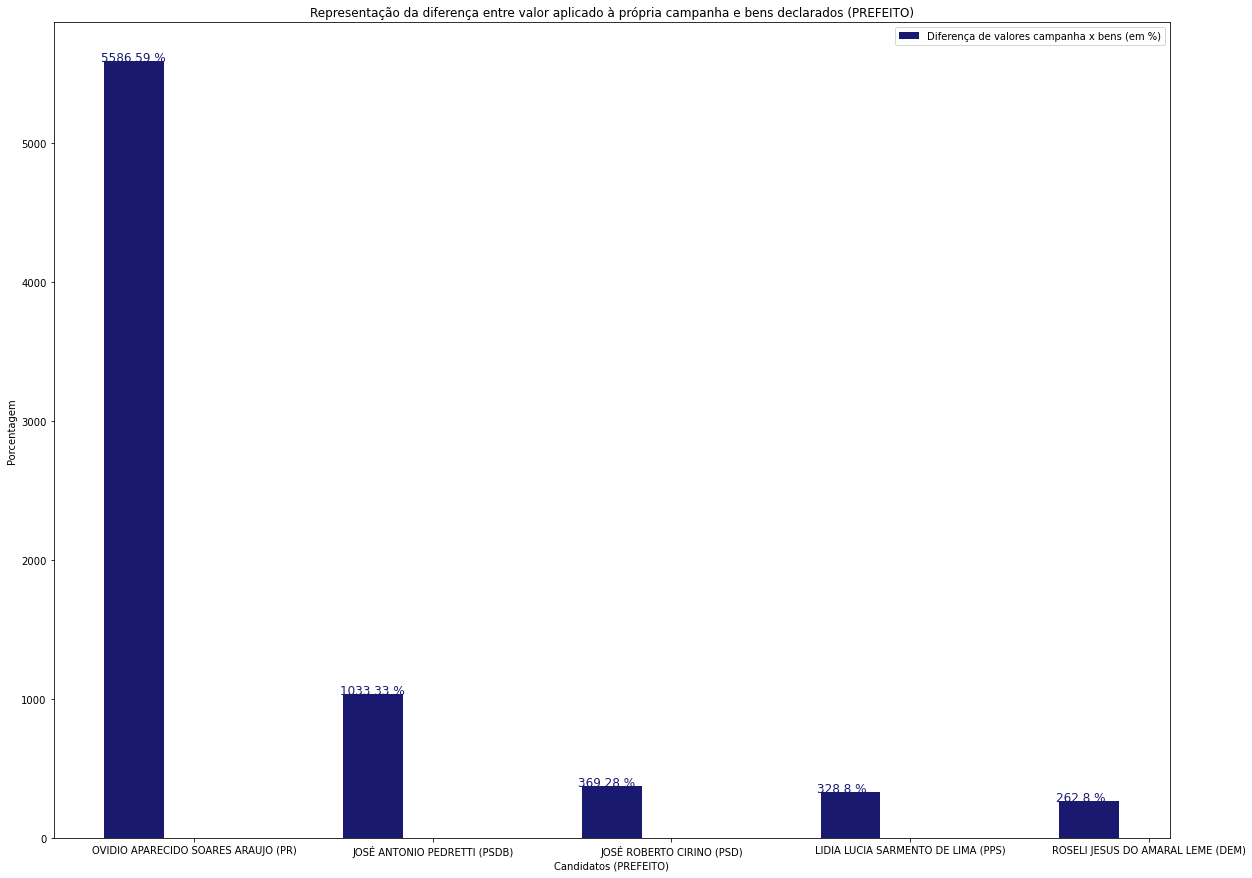

In [5]:
gera_grafico_cinco_primeiros_porcentagem(candidatos_df, 'PREFEITO')


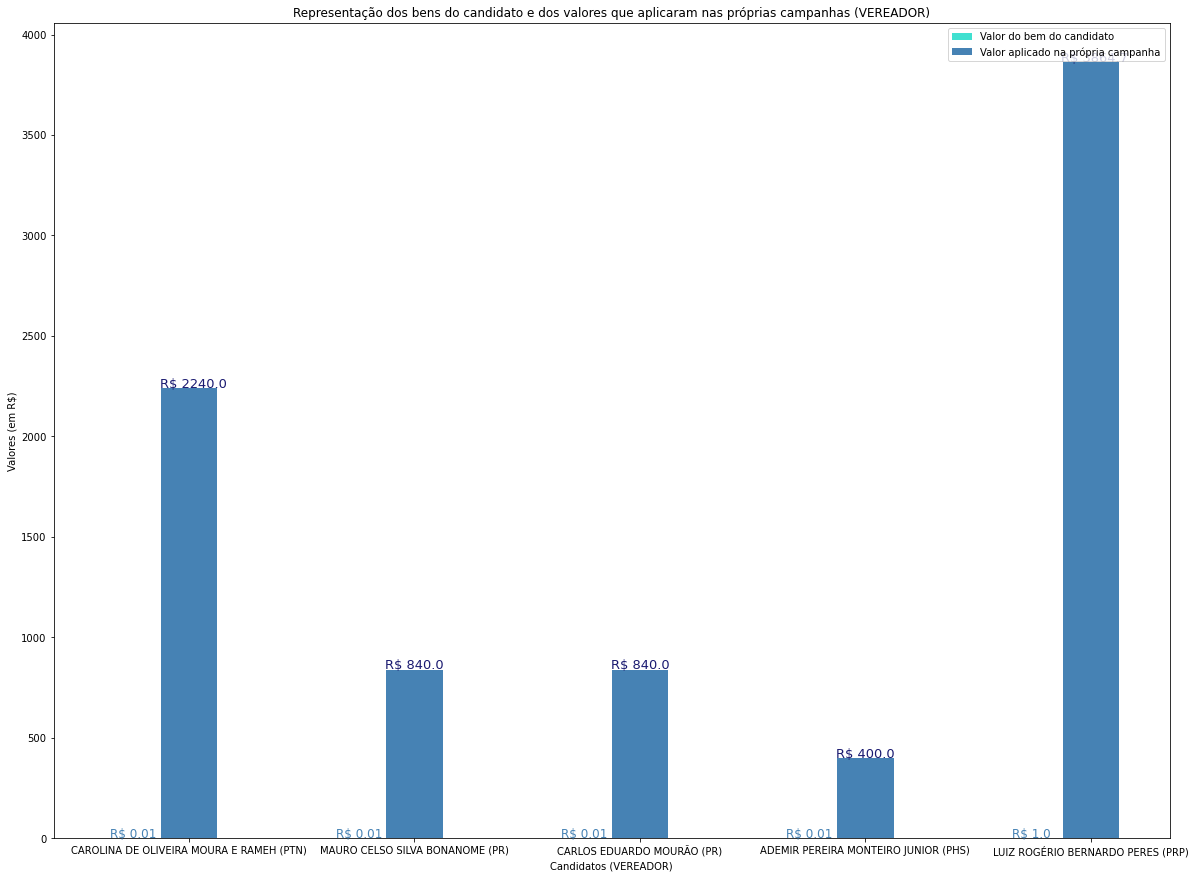

In [6]:
gera_grafico_cinco_primeiros_valores(candidatos_df, 'VEREADOR')


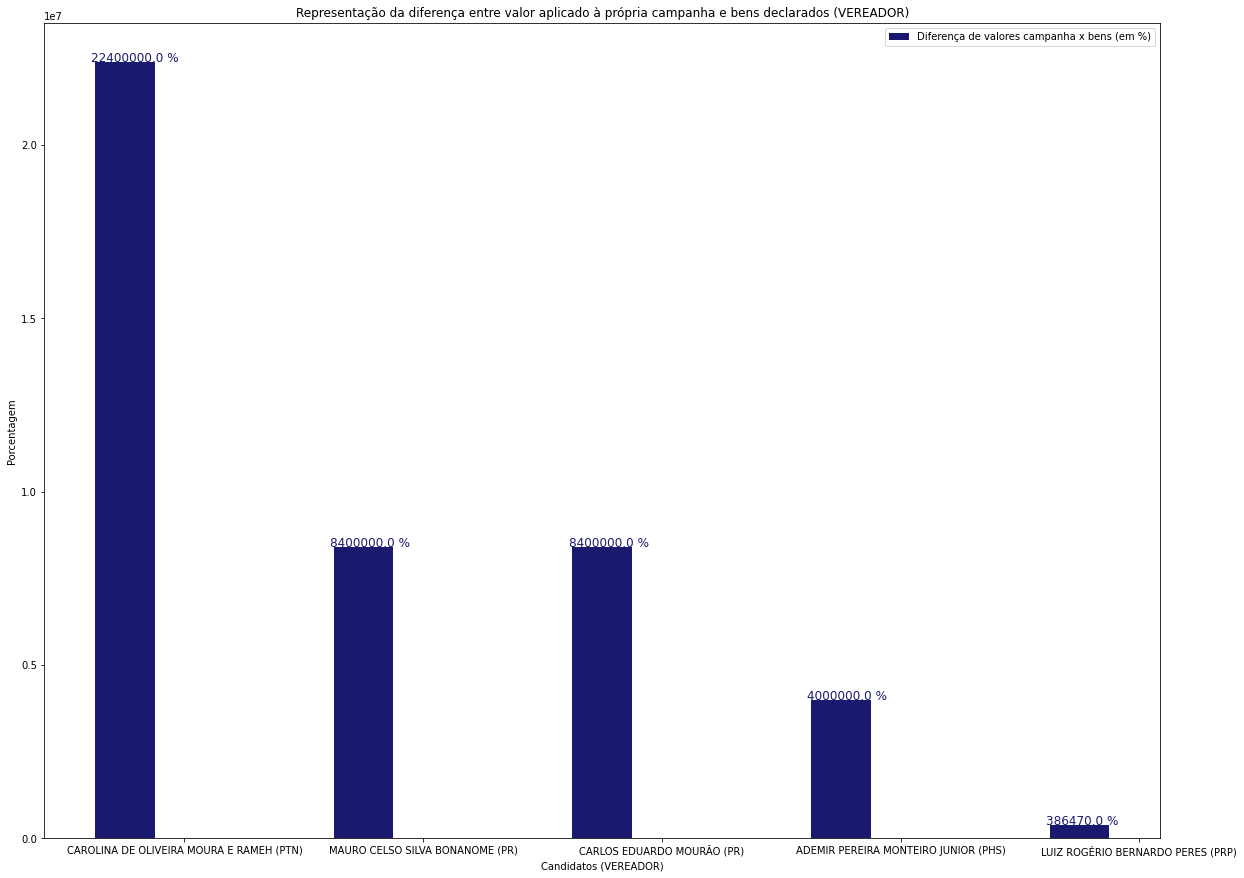

In [7]:
gera_grafico_cinco_primeiros_porcentagem(candidatos_df, 'VEREADOR')
